# Introduction

This paper implements the LeNet-5 model outlined in:

Y. Lecun, L. Bottou, Y. Bengio and P. Haffner, "Gradient-based learning applied to document recognition," in Proceedings of the IEEE, vol. 86, no. 11, pp. 2278-2324, Nov. 1998, [https://doi.org/10.1109/5.726791](http://).

In [1]:
# imports
import numpy as np
import keras
from keras import layers
from keras import losses
from keras import ops
from keras import optimizers
from keras import utils
from keras.datasets import mnist
from keras.ops import image
from keras.optimizers import schedules
import tensorflow as tf
from tensorflow import math
import matplotlib.pyplot as plt

ERROR! Session/line number was not unique in database. History logging moved to new session 17


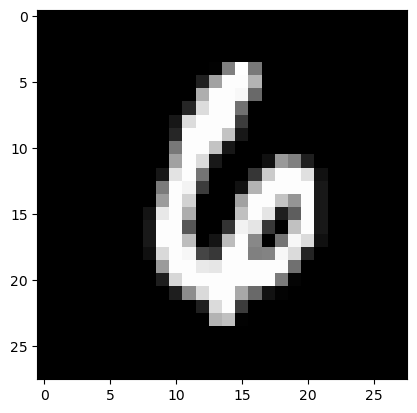

In [2]:
# Load data
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()

# Plot an example:
plt.imshow(x_train_raw[39, :, :], cmap='gray')

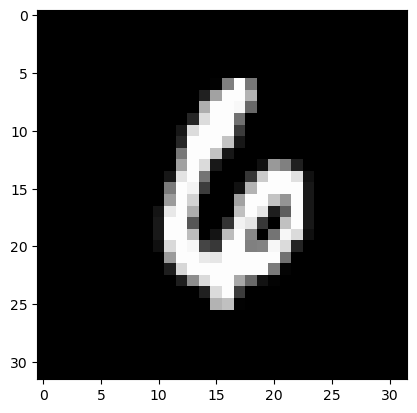

In [3]:
# Preprocess images
x_train = image.pad_images(
    x_train_raw,
    top_padding=2,
    left_padding=2,
    bottom_padding=2,
    right_padding=2,
    data_format="channels_first",
)

x_test = image.pad_images(
    x_test_raw,
    top_padding=2,
    left_padding=2,
    bottom_padding=2,
    right_padding=2,
    data_format="channels_first",
)

y_train = utils.to_categorical(y_train_raw, num_classes=10)
y_test = utils.to_categorical(y_test_raw, num_classes=10)

# Validate example:
plt.imshow(x_train[39, :, :], cmap='gray')

In [4]:
# Constants for the squash function
A = tf.constant(1.7159)
S = tf.constant(2.0 / 3.0)

# This is the "sigmoid" function referenced in the paper
def squash(a):
    scaled = math.scalar_mul(S, a)
    transformed = math.tanh(scaled)
    return math.scalar_mul(A, transformed)

In [5]:
# A custom layer to represent the Euclidean RBF
class EuclideanRBF(layers.Layer):
    def __init__(self, units, **kwargs):
        super(EuclideanRBF, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(self.units, input_shape[1]),
            initializer='uniform',
            trainable=True,
        )
        super(EuclideanRBF, self).build(input_shape)
        
    def call(self, inputs):
        x = ops.broadcast_to(inputs, self.w.shape())
        y = ops.sum(ops.square(x - self.w), axis=1)
        return y

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units,)

In [6]:
# Create the model
def leNet5(squash_fn):
    model = keras.Sequential()
    model.add(keras.Input(shape=(32,32,1)))
    model.add(layers.Conv2D(6, (5, 5)))
    model.add(layers.AveragePooling2D((2 ,2)))
    model.add(layers.Activation(squash_fn))
    model.add(layers.Conv2D(16, (5, 5)))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Activation(squash_fn))
    model.add(layers.Conv2D(120, (5, 5)))
    model.add(layers.Flatten())
    model.add(layers.Dense(84))
    model.add(layers.Activation(squash_fn))
    model.add(layers.Dense(10))
    model.add(layers.Softmax())
    return model

# Compare original squash function against relu
models = [leNet5(s) for s in [ops.relu]]

# Sanity check on a model
models[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train & test the model
def train_test(model, x_train, y_train, x_test, y_test):
    boundaries = [2, 5, 8, 12]
    values = [0.0005, 0.0002, 0.0001, 0.00005, 0.00001]
    learning_rate_fn = schedules.PiecewiseConstantDecay(boundaries, values)
    optimizer = optimizers.SGD(
        learning_rate=learning_rate_fn,
    )
    loss = losses.BinaryCrossentropy()
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[
            'binary_accuracy'
        ],
    )
    model.fit(x_train, y_train, epochs=20, batch_size=1)
    print(model.evaluate(x_test, y_test))

for model in models:
    train_test(model, x_train, y_train, x_test, y_test)


Epoch 1/20
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 32s 529us/step - binary_accuracy: 0.9294 - loss: 0.2590
Epoch 2/20
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 32s 527us/step - binary_accuracy: 0.9761 - loss: 0.0909
Epoch 3/20
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 32s 532us/step - binary_accuracy: 0.9808 - loss: 0.0732
Epoch 4/20
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 32s 529us/step - binary_accuracy: 0.9828 - loss: 0.0657
Epoch 5/20
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 32s 529us/step - binary_accuracy: 0.9849 - loss: 0.0587
Epoch 6/20
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 32s 531us/step - binary_accuracy: 0.9858 - loss: 0.0543
Epoch 7/20
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 32s 532us/step - binary_accuracy: 0.9869 - loss: 0.0512
Epoch 8/20
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 32s 533us/step - binary_accuracy: 0.9872 - loss: 0.0487
Epoch 9/20
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 32s 532us/step - binary_accuracy: 0.9880 - loss: 0.0460
Epoch 10/20
60000/60000 ━━━━━━━━━━━━━━━━━━━━ 32s 534us/step - binary_accuracy: 0.9881 - loss: 0.0451